# Using the GradientIMNN
With a generative model built in ``jax`` for example we can calculate the derivatives of some simulations with which we can use the chain rule to calculate the derivatives of the network outputs with respect to the physical model parameters necessary to fit an IMNN. Note that with a fixed data set for training an IMNN it is important to have a validation set for early stopping. This is because, with a limited training set there *will* be accidental correlations which look like they are due to parameters and the IMNN *will* extract these features. Using a validation set for early stopping makes sure that once all the features in the validation set have been extracted then no extra information can be incorrectly processed.

For this example we are going to summaries the unknown mean, $\mu$, and variance, $\Sigma$, of $n_{\bf d}=10$ data points of two 1D random Gaussian field, ${\bf d}=\{d_i\sim\mathcal{N}(\mu,\Sigma)|i\in[1, n_{\bf d}]\}$. This is an interesting problem since we know the likelihood analytically, but it is non-Gaussian
$$\mathcal{L}({\bf d}|\mu,\Sigma) = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{(d_i-\mu)^2}{\Sigma}\right]$$

As well as knowing the likelihood for this problem, we also know what sufficient statistics describe the mean and variance of the data - they are the mean and the variance
$$\frac{1}{n_{\bf d}}\sum_i^{n_{\bf d}}d_i = \mu\textrm{  and  }\frac{1}{n_{\bf d}-1}\sum_i^{n_{\bf d}}(d_i-\mu)^2=\Sigma$$
What makes this an interesting problem for the IMNN is the fact that the sufficient statistic for the variance is non-linear, i.e. it is a sum of the square of the data, and so linear methods like MOPED would be lossy in terms of information.

We can calculate the Fisher information by taking the negative second derivative of the likelihood taking the expectation by inserting the relations for the sufficient statistics, i.e. and examining at the fiducial parameter values
$${\bf F}_{\alpha\beta} = -\left.\left(\begin{array}{cc}\displaystyle-\frac{n_{\bf d}}{\Sigma}&0\\0&\displaystyle-\frac{n_{\bf d}}{2\Sigma^2}\end{array}\right)\right|_{\Sigma=\Sigma^{\textrm{fid}}}.$$

Choosing fiducial parameter values of $\mu^\textrm{fid}=0$ and $\Sigma^\textrm{fid}=1$ we find that the determinant of the Fisher information matrix is $|{\bf F}_{\alpha\beta}|=50$.

In [1]:
from imnn import GradientIMNN

from imnn.utils import value_and_jacfwd

import jax
import jax.numpy as np
from jax.experimental import stax, optimizers

We're going to use 1000 summary vectors, with a length of two, at a time to make an estimate of the covariance of network outputs and the derivative of the mean of the network outputs with respect to the two model parameters.

In [2]:
n_s = 1000
n_d = n_s

n_params = 2
n_summaries = n_params

input_shape = (10,)

The simulator is simply

In [3]:
def simulator(key, θ):
    return θ[0] + jax.random.normal(key, shape=input_shape) * np.sqrt(θ[1])

Our fiducial parameter values are $\mu^\textrm{fid}=0$ and $\Sigma^\textrm{fid}=1$

In [ ]:
θ_fid = np.array([0., 1.])

We can generate the simulations using:

In [5]:
get_sims_and_ders = value_and_jacfwd(simulator, argnums=1)

For initialising the neural network we need a random number generator and we'll grab another for generating the data:

In [6]:
rng = jax.random.PRNGKey(1)
rng, model_key, data_key = jax.random.split(rng, num=3)

We'll make the keys for each of the simulations for fitting and validation

In [7]:
data_keys = np.array(jax.random.split(rng, num=2 * n_s))

In [8]:
fiducial, derivative = jax.vmap(get_sims_and_ders)(
    data_keys[:n_s], np.repeat(np.expand_dims(θ_fid, 0), n_s, axis=0))
validation_fiducial, validation_derivative = jax.vmap(get_sims_and_ders)(
    data_keys[n_s:], np.repeat(np.expand_dims(θ_fid, 0), n_s, axis=0))

We're going to use ``jax``'s stax module to build a simple network with three hidden layers each with 128 neurons and which are activated by leaky relu before outputting the two summaries. The optimiser will be a ``jax`` Adam optimiser with a step size of 0.001.

In [9]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries))
optimiser = optimizers.adam(step_size=1e-3)

The GradientIMNN can now be initialised setting up the network and the fitting routine (as well as the plotting function)

In [10]:
imnn = GradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries, 
    input_shape=input_shape, θ_fid=θ_fid, model=model, 
    optimiser=optimiser, key_or_state=model_key, 
    fiducial=fiducial, derivative=derivative, 
    validation_fiducial=validation_fiducial, 
    validation_derivative=validation_derivative)

To set the scale of the regularisation we use a coupling strength $\lambda$ whose value should mean that the determinant of the difference between the covariance of network outputs and the identity matrix is larger than the expected initial value of the determinant of the Fisher information matrix from the network. How close to the identity matrix the covariance should be is set by $\epsilon$. These parameters should not be very important, but they will help with convergence time.

In [11]:
λ = 10.
ϵ = 0.1

Fitting can then be done simply by calling:

In [12]:
imnn.fit(λ, ϵ, print_rate=1)

0it [00:00, ?it/s]

Here we have included a ``print_rate`` for a progress bar, but leaving this out will massively reduce fitting time (at the expense of not knowing how many iterations have been run). The IMNN is run (by default) for a maximum of ``max_iterations = 100000`` iterations, but with early stopping which can turn on after ``min_iterations = 100`` iterations and after ``patience = 100`` iterations where the maximum determinant of the Fisher information matrix has not increased. ``imnn.w`` is set to the values of the network parameters which obtained the highest value of the determinant of the Fisher information matrix, but the values at the final iteration can be set using ``best = False``.

To continue training one can simply rerun fit

In [13]:
imnn.fit(λ, ϵ, print_rate=1)

0it [00:00, ?it/s]

To visualise the fitting history we can plot the results:

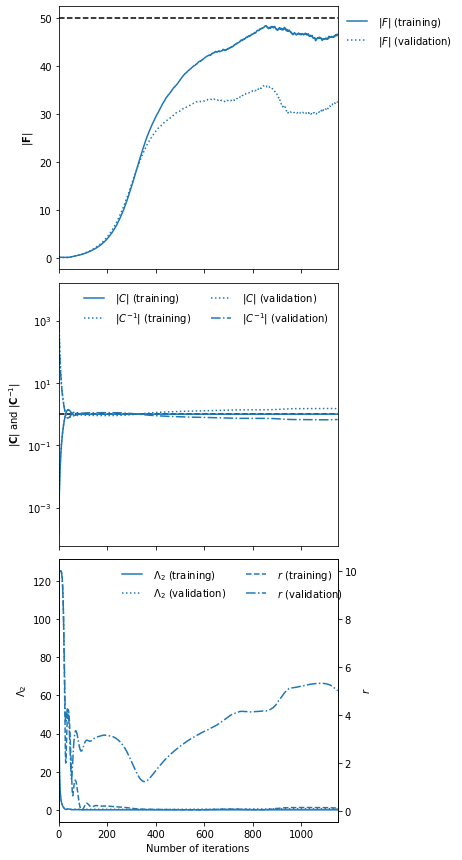

In [14]:
imnn.plot(expected_detF=50);